In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import mean_absolute_error
import warnings
from math import gcd
from functools import reduce
warnings.filterwarnings("ignore")

# Config Set up

In [2]:
def lcm(a, b):
    return abs(a*b) // gcd(a, b) if a and b else 0

def get_valid_h(base_h=128, R=3, kernel_count=3, num_heads=8):
    # h phải chia hết cho (R * kernel_count) và num_heads
    divisor = lcm(R * kernel_count, num_heads)
    for h in range(((base_h - 1) // divisor + 1) * divisor, base_h + 1000, divisor):
        if h >= base_h:
            return h
    raise ValueError(f"Không tìm được h >= {base_h} chia hết cho {divisor}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T, R = 60, 3
d = 64                    # 19 (room+env) + 45 (news PCA) = 64
num_heads = 8
kernel_count= 3
num_layers = 3
M = 3                     # MDN mixtures
BATCH_SIZE = 16
EPOCHS = 100
LR = 1e-4
PATIENCE = 10
h = get_valid_h(128, R, kernel_count, num_heads)

INPUT_NPZ = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/preprocessed_data.npz"
SCALERS_PKL = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/scalers.pkl"
MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Basic_Dynamic_Prices_base_on_Demand_Model/Output/rpt_demand_best.pth"

print(f"[AUTO] h = {h}")
print(f"   → h % (R*{kernel_count}) = {h % 9} = 0")
print(f"   → h % num_heads = {h % 8} = 0")
print(f"[AUTO] h = {h} → per_room: {h//R}, per_kernel: {h//9}, head_dim: {h//8}")

[AUTO] h = 144
   → h % (R*3) = 0 = 0
   → h % num_heads = 0 = 0
[AUTO] h = 144 → per_room: 48, per_kernel: 16, head_dim: 18


# Load Data

In [3]:
data = np.load(INPUT_NPZ, allow_pickle=True)
X = data['X'].astype(np.float32)              # (227,60,3,24)
news_emb = data['news_emb'].astype(np.float32) # (227,60,40) ← bắt buộc phải có
y_demand = data['y_demand'].astype(np.float32)
dates = data['dates']

with open(SCALERS_PKL, 'rb') as f:
    scalers = pickle.load(f)
price_scaler = scalers['price_scaler']
revenue_scaler = scalers['revenue_scaler']
demand_scaler = scalers['solds_scaler']

print(f"[INFO] X: {X.shape}, y_demand: {y_demand.shape}, news: {news_emb.shape}")

# Split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y_demand[:split], y_demand[split:]
news_train, news_val = news_emb[:split], news_emb[split:]

[INFO] X: (227, 60, 3, 24), y_demand: (227, 3), news: (227, 60, 40)


In [4]:
class RPTDataset(Dataset):
    def __init__(self, X, news_emb, y):
        """
        X: (N, 60, 3, 24)  → historical features
        news_emb: (N, 60, 40) → news embedding riêng
        y: (N, 3) → demand 3 loại phòng
        """
        assert len(X) == len(news_emb) == len(y), "Số lượng mẫu không khớp!"
        self.X = torch.from_numpy(X).float()
        self.news_emb = torch.from_numpy(news_emb).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],           # (60, 3, 24)
            self.y[idx],           # (3,)
            self.news_emb[idx]     # (60, 40)
        )

In [5]:
train_dataset = RPTDataset(X_train, news_train, y_train)  # Sửa thành _dataset
val_dataset = RPTDataset(X_val, news_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# RPT model

## RPT Encoder

In [6]:
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        assert out_channels % 3 == 0, f"out_channels={out_channels} phải chia hết 3"
        self.conv = nn.ModuleList([
            nn.Conv1d(in_channels, out_channels//3, k, padding=k//2)
            for k in [1, 3, 5]
        ])
    def forward(self, x):
        return torch.cat([conv(x) for conv in self.conv], dim=1)

In [7]:
class CrossAttention(nn.Module):
    def __init__(self, dim_model, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim_model, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(dim_model)
    def forward(self, q, k, v):
        out, _ = self.attn(q, k, v)
        return self.norm(q + out)

In [8]:
class RPTEncoder(nn.Module):
    def __init__(self, d_room=24, embed_dim_news=40, h=144, R=3):
        super().__init__()
        self.h = h

        # 1. Temporal Conv: 3 loại phòng × 24 features = 72 channels
        self.temporal_conv = TemporalConv(R * d_room, h)   # 72 → 144

        # 2. News projection
        self.news_proj = nn.Linear(embed_dim_news, h)      # 40 → 144
        self.news_norm = nn.LayerNorm(h)                   # ← THÊM DÒNG NÀY

        # 3. Self-attention + residual norm
        self.self_attn = nn.MultiheadAttention(h, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(h)                       # ← THÊM DÒNG NÀY

        # 4. Cross-attention
        self.cross_attn = CrossAttention(h, num_heads)

        # 5. Bilinear + Fusion
        self.bilinear = nn.Parameter(torch.randn(h, h))
        self.norm2 = nn.LayerNorm(h)                       # ← THÊM DÒNG NÀY
        self.fusion = nn.Parameter(torch.ones(2))

    def forward(self, x, news_emb):
        B, T, R, d = x.shape
        assert R == 3 and d == 24
        assert news_emb.shape == (B, T, 40)

        # Gộp 3 loại phòng → 72 chiều
        x = x.view(B, T, -1)                               # (B, T, 72)

        # Temporal Conv
        h = self.temporal_conv(x.transpose(1, 2)).transpose(1, 2)  # (B, T, 144)

        # Self-attention + norm
        h = h + self.self_attn(h, h, h)[0]
        h = self.norm1(h)                                  # ← giờ có norm1 rồi!

        # News cross-attention
        news_proj = self.news_proj(news_emb)
        news_proj = self.news_norm(news_proj)              # ← giờ có news_norm rồi!
        h = h + self.cross_attn(h, news_proj, news_proj)[0]

        # Bilinear interaction
        h_left = torch.matmul(h, self.bilinear)          # (B, T, h)
        M = torch.matmul(h_left, h.transpose(-1, -2))
        w1, w2 = self.fusion.softmax(0)
        h_bilinear = torch.matmul(M, h)

        h_fused = w1 * h + w2 * h_bilinear

        return self.norm2(h_fused)                         # ← giờ có norm2 rồi!

## RPT Decoder

In [9]:
class MDNHead(nn.Module):
    def __init__(self, input_dim, M=3, output_dim=3):
        super().__init__()
        self.M, self.output_dim = M, output_dim
        self.pi_net = nn.Sequential(nn.Linear(input_dim, M), nn.Softmax(dim=-1))
        self.mu_net = nn.Linear(input_dim, M * output_dim)
        self.sigma_net = nn.Sequential(nn.Linear(input_dim, M * output_dim), nn.Softplus())

    def forward(self, x):
        B = x.size(0)
        pi = self.pi_net(x)
        mu = self.mu_net(x).view(B, self.M, self.output_dim)
        sigma = self.sigma_net(x).view(B, self.M, self.output_dim) + 1e-6
        return pi, mu, sigma

In [10]:
def mdn_loss(pi, mu, sigma, y):
    y = y.unsqueeze(1)  # (B,1,3)
    gaussian = torch.exp(-0.5 * ((y - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))
    likelihood = (pi.unsqueeze(-1) * gaussian).sum(dim=1)  # (B,3)
    return -torch.log(likelihood + 1e-8).mean()

In [11]:
class RPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = RPTEncoder(d_room=24, embed_dim_news=40, h=144, R=3)
        self.mdn = MDNHead(144, M=3, output_dim=3)
    def forward(self, x, news_emb):
        return self.mdn(self.encoder(x, news_emb).mean(dim=1))

# Train Phase

In [12]:
def plot_training_history(train_losses, val_maes, best_epoch, model, val_loader, demand_scaler):
    plt.figure(figsize=(15, 5))

    # Plot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='#1f77b4', linewidth=2)
    plt.title('Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True, alpha=0.3); plt.legend()

    # Plot 2: Val MAE
    plt.subplot(1, 3, 2)
    plt.plot(val_maes, label='Val MAE (phòng)', color='#ff7f0e', linewidth=2.5, marker='o')
    plt.axvline(best_epoch, color='green', linestyle='--', label=f'Best: {min(val_maes):.3f}')
    plt.scatter(best_epoch, min(val_maes), color='red', s=120, zorder=5)
    plt.title('Validation MAE (Real Rooms)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch'); plt.ylabel('MAE (phòng)'); plt.grid(True, alpha=0.3); plt.legend()

    # Plot 3: Dự báo vs thực tế
    model.eval()
    actuals, forecasts = [], []
    with torch.no_grad():
        for xb, yb, newsb in val_loader:
            xb, yb, newsb = xb.to(DEVICE), yb.to(DEVICE), newsb.to(DEVICE)
            pi, mu, _ = model(xb, newsb)
            pred = (pi.unsqueeze(-1) * mu).sum(1)
            pred = demand_scaler.inverse_transform(pred.cpu().numpy())
            true = demand_scaler.inverse_transform(yb.cpu().numpy())
            actuals.append(true[-1])
            forecasts.append(pred[-1])
            if len(actuals) >= 5: break

    plt.subplot(1, 3, 3)
    x = np.arange(3)
    width = 0.35
    room_types = ['Single', 'Double', 'VIP']
    last_true = actuals[-1].round()
    last_pred = forecasts[-1].round()
    plt.bar(x - width/2, last_true, width, label='Thực tế', color='#2ca02c', alpha=0.8)
    plt.bar(x + width/2, last_pred, width, label='Dự báo', color='#d62728', alpha=0.8)
    plt.xticks(x, room_types, fontweight='bold')
    plt.ylabel('Số phòng'); plt.title('Dự báo vs Thực tế (ngày cuối)', fontsize=14, fontweight='bold')
    plt.legend(); plt.grid(True, alpha=0.3, axis='y')

    plt.suptitle('RPT Model - Kết Quả Huấn Luyện (2025)', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [13]:
def train_rpt(model, train_loader, val_loader, optimizer, epochs=100, patience=10):
    train_losses, val_maes = [], []
    best_mae = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb, newsb in train_loader:
            xb, yb, newsb = xb.to(DEVICE), yb.to(DEVICE), newsb.to(DEVICE)
            pi, mu, sigma = model(xb, newsb)
            loss = mdn_loss(pi, mu, sigma, yb)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Validation với inverse scaler (đúng MAE thực tế)
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb, newsb in val_loader:
                xb, yb, newsb = xb.to(DEVICE), yb.to(DEVICE), newsb.to(DEVICE)
                pi, mu, _ = model(xb, newsb)
                pred = (pi.unsqueeze(-1) * mu).sum(1)
                pred = demand_scaler.inverse_transform(pred.cpu().numpy())
                true = demand_scaler.inverse_transform(yb.cpu().numpy())
                preds.extend(pred)
                trues.extend(true)
        mae = mean_absolute_error(trues, preds)
        val_maes.append(mae)

        print(f"Epoch {epoch+1:3d} | Loss: {train_losses[-1]:.6f} | Val MAE: {mae:.3f} phòng")

        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch
            torch.save(model.state_dict(), MODEL_PATH)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping tại epoch {epoch+1}")
                break

    print(f"\nBEST VAL MAE: {best_mae:.3f} phòng (epoch {best_epoch+1})")

    # VẼ ĐỒ THỊ SAU KHI TRAIN XONG
    plot_training_history(train_losses, val_maes, best_epoch, model, val_loader, demand_scaler)

    return best_mae

# Predict demand

In [14]:
def predict_demand(model, last_window, news_emb_last):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(last_window).float().unsqueeze(0).to(DEVICE)      # (1,60,3,24)
        news = torch.from_numpy(news_emb_last).float().unsqueeze(0).to(DEVICE) # (1,60,40)

        pi, mu, sigma = model(x, news)
        pred_scaled = (pi.unsqueeze(-1) * mu).sum(dim=1).cpu().numpy()         # (1,3)

        # === FIX QUAN TRỌNG: ĐẢM BẢO THỨ TỰ CỘT ĐÚNG [Single, Double, VIP] ===
        pred_raw = demand_scaler.inverse_transform(pred_scaled)[0]            # ← đúng thứ tự!
        pred_raw = np.clip(pred_raw, 0, None)

    return {
        'single': int(round(pred_raw[0])),
        'double': int(round(pred_raw[1])),
        'vip'   : int(round(pred_raw[2]))
    }

# Main

In [15]:
def main():
    print("=== RPT: DEMAND FORECASTING & DYNAMIC PRICING ===")
    model = RPTModel().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    # Huấn luyện
    train_rpt(model, train_loader, val_loader, optimizer)

    # Load best model
    model.load_state_dict(torch.load(MODEL_PATH))

    last_x = X[-1]        # (60,3,24) – full historical features
    last_news = news_emb[-1]  # (60,40) – news riêng

    # Dự báo demand
    pred = predict_demand(model, last_x, last_news)

    # In kết quả
    tomorrow = pd.to_datetime(dates[-1]) + pd.Timedelta(days=1)
    print(f"\n=== DỰ BÁO DEMAND NGÀY {tomorrow:%d/%m/%Y} ===")
    print(f"   • Single: {pred['single']} phòng")
    print(f"   • Double: {pred['double']} phòng")
    print(f"   • VIP:    {pred['vip']} phòng")
    print(f"   • Tổng:   {pred['single'] + pred['double'] + pred['vip']} phòng")

    return model, pred

=== RPT: DEMAND FORECASTING & DYNAMIC PRICING ===
Epoch   1 | Loss: 15.655477 | Val MAE: 368.924 phòng
Epoch   2 | Loss: 13.784209 | Val MAE: 359.957 phòng
Epoch   3 | Loss: 13.328676 | Val MAE: 347.290 phòng
Epoch   4 | Loss: 13.135253 | Val MAE: 336.825 phòng
Epoch   5 | Loss: 12.990631 | Val MAE: 335.528 phòng
Epoch   6 | Loss: 12.908246 | Val MAE: 337.036 phòng
Epoch   7 | Loss: 12.896800 | Val MAE: 337.000 phòng
Epoch   8 | Loss: 12.894810 | Val MAE: 337.260 phòng
Epoch   9 | Loss: 12.886005 | Val MAE: 337.135 phòng
Epoch  10 | Loss: 12.889815 | Val MAE: 337.451 phòng
Epoch  11 | Loss: 12.884387 | Val MAE: 337.974 phòng
Epoch  12 | Loss: 12.884548 | Val MAE: 337.657 phòng
Epoch  13 | Loss: 12.883798 | Val MAE: 337.742 phòng
Epoch  14 | Loss: 12.898795 | Val MAE: 337.987 phòng
Epoch  15 | Loss: 12.889147 | Val MAE: 337.411 phòng
Early stopping tại epoch 15

BEST VAL MAE: 335.528 phòng (epoch 5)


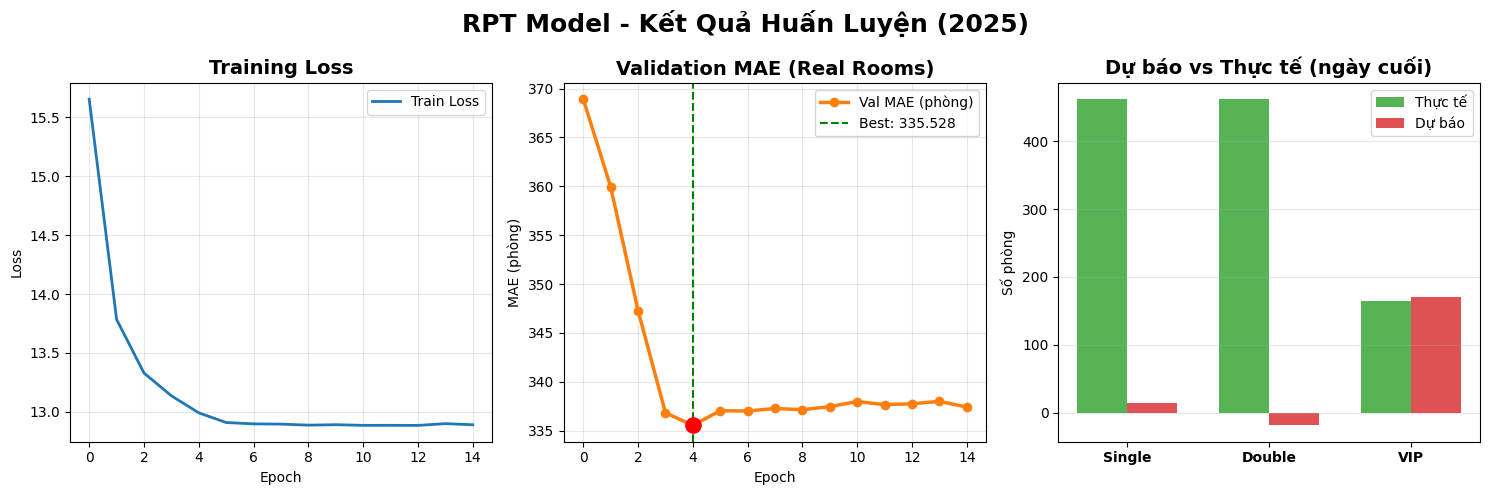


=== DỰ BÁO DEMAND NGÀY 31/12/2024 ===
   • Single: 17 phòng
   • Double: 0 phòng
   • VIP:    154 phòng
   • Tổng:   171 phòng


In [16]:
if __name__ == "__main__":
    model, pred = main()